In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dlib
import cv2

In [2]:
def rect_to_bb(rect):
    x = rect.left()
    y = rect.top()    
    w = rect.right() - x
    h = rect.bottom() - y
    
    return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
    coords = np.zeros((68, 2), dtype=dtype)
 
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    
    return coords

El objetivo de este libreta es sentar las bases para el proyecto de este periodo parcial que consistirá en el **morphing** de imágenes. La idea principal del morphing es la de aplicar homografías a diferentes secciones de una imagen hasta que se transforme, suavemente, en otra. Esta técnica es muy popular entre los equipos de efectos especiales, como puedes ver en el video ubicado en el siguiente enlace [minuto 5:27]:

<a href="https://www.youtube.com/watch?v=F2AitTPI5U0"> Video morphing </a> 

Exploraremos la idea basándonos en el alineamiento de rostros humanos. 


# Alineamiento de rostros

En las sesiones anteriores logramos la recuperación de una homografía, que permitió alinear a un par de imágenes, tomando como base la identificación de puntos correspondientes en sus envolventes convexas. En esta sección extenderemos esa estrategia pero ahora basándonos en marcadores distintivos identificados en rostros humanos.

Imagina que tenemos un par de imágenes correspondientes al rostro de una misma persona y que estas imágenes fueron capturadas desde diferentes perspectivas. Suponemos que existe una homografía que permite alinear una de las imágenes con la otra y nuestro objetivo es encontrarla. 

En las siguiente celdas produciremos, sintéticamente, un par de imágenes para ilustrar el problema.



# Homografía aplicada a una imagen

Para iniciar, cargaremos una imagen que contiene un rostro muy famoso y la transformaremos aplicando una homografía. 

In [3]:
#matriz de mografía
H = np.array([[1.1, 0.2, 0], [-0.1, 0.98, 0], [0, 0.001, 1]])

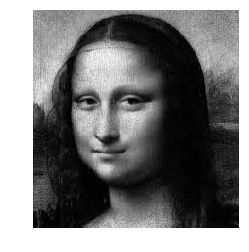

(231L, 218L)


In [4]:
#lee una imagen para transformarla aplicándole la homografía
im = cv2.imread("mona.jpg",0)
plt.imshow(im, cmap="gray")
plt.axis("off")
plt.show()

print im.shape


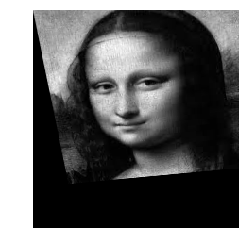

(231L, 218L)


In [5]:
im2 = cv2.warpPerspective(im,H,(im.shape[1],im.shape[0]))

plt.imshow(im2,cmap="gray")
plt.axis("off")
plt.show()

print im2.shape

Puedes suponer que las imágenes que construimos corresponden a un mismo rostro observado desde diferentes perspectivas:

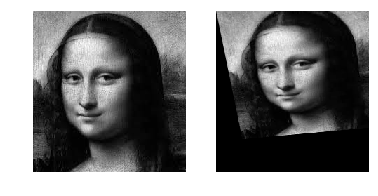

In [6]:
plt.subplot(121)
plt.imshow(im,cmap="gray")
plt.axis("off")

plt.subplot(122)
plt.imshow(im2,cmap="gray")
plt.axis("off")

plt.show()


La estrategia que seguiremos para determinar la homografía alinee ambas imágenes es la siguiente:

* Detectaremos el rostro en cada imagen y lo delimitaremos con un rectángulo. 
* En cada rectángulo aplicaremos un clasificador entrenado para detectar un conjunto de marcadores sobre rostros [puntos distintivos como los extremos de los labios o los ojos]
* Considerando que los dos conjuntos de marcadores son correspondientes utilizaremos mínimos cuadrados [o la rutina de OpenCV] para estimar la homografía.  



# Detección de rostros 



In [7]:
#construimos el detector de puntos de interés
detector = dlib.get_frontal_face_detector()

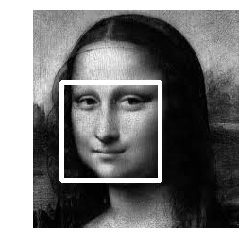

In [8]:
#el detector regresa un arreglo de rectángulos que delimita cada rostro detectado
rects = detector(im)

#mostramos el rectángulo que delimita el rostro
im_copy = im.copy()
cv2.rectangle(im_copy,(rects[0].left(), rects[0].top()),(rects[0].right(), rects[0].bottom()),(255,255,255),3)

plt.imshow(im_copy,cmap="gray")
plt.axis("off")
plt.show()

# Face features (puntos de interés en rostros)

In [9]:
#aplicamos el predictor sobre la imagen de interés

#el archivo contiene los parámetros necesarios para que el 
#clasificador identifique los marcadores en rostros
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
shape = predictor(im, rects[0])
shape = shape_to_np(shape)
len(shape) #68 marcadores

68

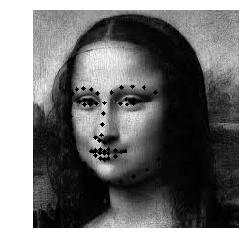

In [10]:
#mostramos los marcadores
im_copy = im.copy()

for (x, y) in shape:
    cv2.circle(im_copy, (x, y), 2, (0, 0, 255), -1)
    
plt.imshow(im_copy,cmap="gray")
plt.axis("off")
plt.show()

Aplicamos el mismo proceso sobre la imagen objetivo para obtener las correspondencias

In [11]:
rects2 = detector(im2) 
shape2 = predictor(im2, rects2[0])
shape2 = shape_to_np(shape2)
len(shape2)

68

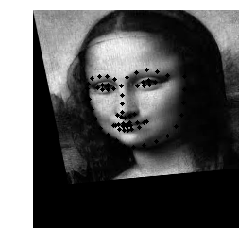

In [12]:
#mostramos los puntos de interés
im2_copy = im2.copy()

for (x, y) in shape2:
    cv2.circle(im2_copy, (x, y), 2, (0, 0, 255), -1)
    
plt.imshow(im2_copy,cmap="gray")
plt.axis("off")
plt.show()

## Recuperación de la homografía

In [13]:
pts1 = 1.0*shape # multiplicamos por 1.0 para forzar a que los datos tengan el tipo adecuado
pts2 = 1.0*shape2

h, v = cv2.findHomography(pts1,pts2)

La homografía recuperada es:

In [14]:
h

array([[ 1.11165031e+00,  1.47912229e-01,  3.13050921e+00],
       [-3.13538953e-02,  8.93351363e-01,  1.95657423e+00],
       [ 6.93644080e-04,  3.22008614e-04,  1.00000000e+00]])

Alineamos las imágenes:

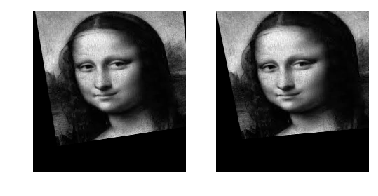

In [15]:
imt = cv2.warpPerspective(im,h,(im.shape[1],im.shape[0]))
plt.subplot(121)
plt.imshow(imt,cmap="gray")
plt.axis("off")
plt.subplot(122)
plt.imshow(im2,cmap="gray")
plt.axis("off")
plt.show()

Aplicamos el mismo proceso en sentido inverso [alineando la imagen dos a la imagen uno]

In [16]:
h, v = cv2.findHomography(pts2,pts1)

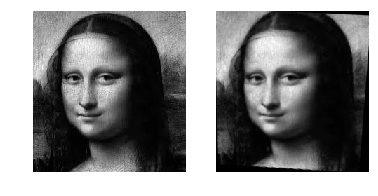

In [17]:
imt = cv2.warpPerspective(im2,h,(im.shape[1],im.shape[0]))
plt.subplot(121)
plt.imshow(im,cmap="gray")
plt.axis("off")
plt.subplot(122)
plt.imshow(imt,cmap="gray")
plt.axis("off")
plt.show()